# Chapter 1

This Jupyter Notebook implements key parts of Chapter 1 of the book "An Introduction to Tsetlin Machines". The complete chapter can be found here: https://www.researchgate.net/publication/354450962_An_Introduction_to_Tsetlin_Machines_Your_First_Tsetlin_Machine.

## Boolean Features

You first need observations that the Tsetlin machine can learn from. The following dataset contains three objects of type _Car_. They are characterized by five Boolean features: _Four Wheels_, _Transports People_, _Wings_, _Yellow_, and _Blue_. The first object in the dataset, for instance, has _Four Wheels_, _Transports People_, does not have _Wings_, is _Blue_, but not _Yellow_. 

In [1]:
cars = [
    {'Four Wheels':True, 'Transports People':True, 'Wings':False, 'Yellow':False, 'Blue':True},
    {'Four Wheels':True, 'Transports People':True, 'Wings':False, 'Yellow':True, 'Blue':False},
    {'Four Wheels':True, 'Transports People':True, 'Wings':False, 'Yellow':True, 'Blue':False}
]

## Creating Patterns with AND and NOT

The Tsetlin machine learns to recognize different object types by creating _if-then rules_. Each rule has the form: __if__ _condition_ __then__ _class_.

The _condition_ is an __and__-expression while the _class_ is a type of object. You can use the method `evaluate_condition()` to evaluate the condition of a rule:

In [2]:
def evaluate_condition(observation, condition):
    truth_value_of_condition = True
    for feature in observation:
        if feature in condition and observation[feature] == False:
            truth_value_of_condition = False
            break
        if 'NOT ' + feature in condition and observation[feature] == True:
            truth_value_of_condition = False
            break
    return truth_value_of_condition

For instance, create the condition

In [3]:
example_condition = ['Four Wheels', 'Transports People', 'NOT Wings']

This condition means: _Four Wheels_ __and__ _Transports People_ __and__ __not__ _Wings_. Now, evaluate the condition on the first object in the dataset:

In [4]:
evaluate_condition(cars[0], example_condition)

True

Since the first object in the dataset has _Four Wheels_, _Transports People_, and does not have _Wings_, the __and__-expression becomes _True_.

## Learning Frequent Patterns with Type I Feedback

### Rule Memory

You are now about to discover how a single if-then rule learns to recognizing frequent _Car_ patterns. To this end, the rule has its own memory for storing literals. The memory simulates memorization and forgetting, visualized in the figure below,

<div>
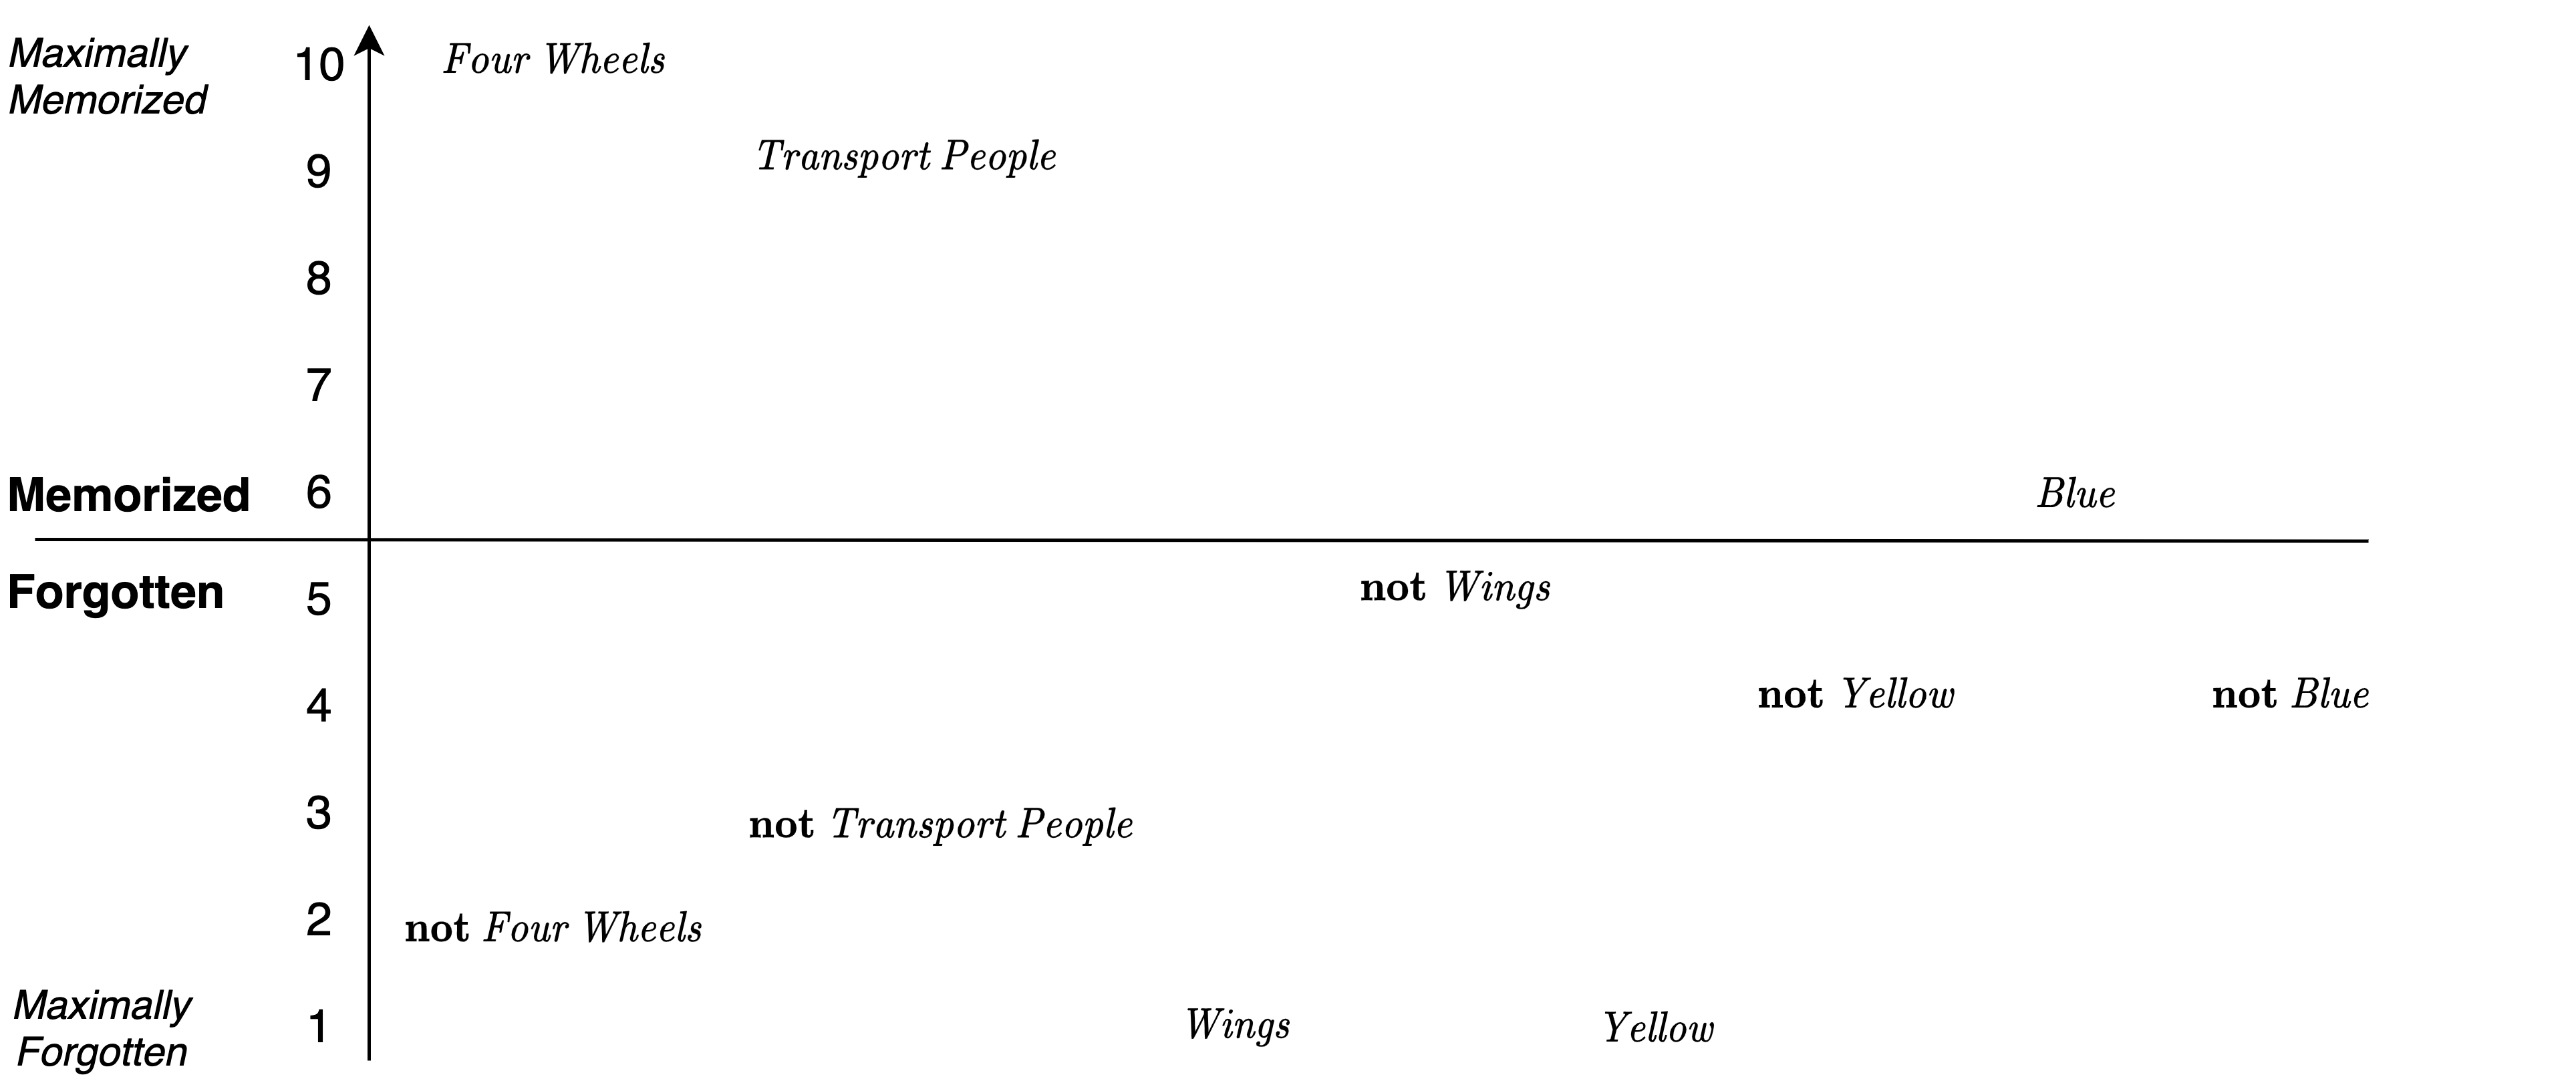
</div>

The y-axis ranges from 1 to 10 and measures how deeply the memory stores each literal:

* Values 1 to 5 stand for _Forgotten_. Value 1 means maximally forgotten while value 5 means almost memorized. Literals in this range _do not_ take part in the rule's condition.
* Values 6 to 10 mean _Memorized_. Value 6 stands for lightly retained, and value 10 represents maximally memorized. Literals in this range take part in the condition of the rule.

You can implement the memory as a class:

In [5]:
class Memory:
    def __init__(self, forget_value, memorize_value, memory):
        self.memory = memory
        self.forget_value = forget_value
        self.memorize_value = memorize_value
    
    def get_memory(self):
        return self.memory
    
    def get_literals(self):
        return list(self.memory.keys())
    
    def get_condition(self):
        condition = []
        for literal in self.memory:
            if self.memory[literal] >= 6:
                condition.append(literal)
        return condition
        
    def memorize(self, literal):
        if random() <= self.memorize_value and self.memory[literal] < 10:
            self.memory[literal] += 1
            
    def forget(self, literal):
        if random() <= self.forget_value and self.memory[literal] > 1:
            self.memory[literal] -= 1
            
    def memorize_always(self, literal):
        if  self.memory[literal] < 10:
            self.memory[literal] += 1

To create the memory for the _Car_ if-then rule, you first set `forget_value`, which decides how quickly the memory forgets. You also set `memorize_value`, determining memorization speed. Finally, you add the literals and their starting memory positions.

In [6]:
car_rule = Memory(0.9, 0.1, {'Four Wheels':10, 'NOT Four Wheels':2, 'Transports People':9, 'NOT Transports People':3, 'Wings':1, 'NOT Wings':5, 'Yellow':1, 'NOT Yellow':4, 'Blue':6, 'NOT Blue':4})

The `get_condition()` method extracts the literals in memory position 6 to 10. You can try `get_condition()` on the above example memory.

In [7]:
car_rule.get_condition()

['Four Wheels', 'Transports People', 'Blue']

The condition is _Four Wheels_ __and__ _Transports People_ __and__ _Blue_. You then get the _Car_ rule:

In [8]:
print("IF " + " AND ".join(car_rule.get_condition()) + " THEN Car")

IF Four Wheels AND Transports People AND Blue THEN Car


### Memorization and Forgetting

You memorize a literal by incrementing its position in memory unless already _Maximally Memorized_ in position 10. The memorization thus pushes the literals deeper into the rule's memory. The `memorize()` method implements memorization.

You forget a literal by decrementing its position in memory unless already Maximally Forgotten in position 1. The `forget()` method implements forgetting.

Both `memorize()` and `forget()` are randomized, hence we need the `random` method from the `random` module:

In [9]:
from random import random

Try out forget two times on literal _Blue_ and observe how the memory updates:

In [10]:
car_rule.forget('Blue')
car_rule.forget('Blue')
print(car_rule.memory)

{'Four Wheels': 10, 'NOT Four Wheels': 2, 'Transports People': 9, 'NOT Transports People': 3, 'Wings': 1, 'NOT Wings': 5, 'Yellow': 1, 'NOT Yellow': 4, 'Blue': 4, 'NOT Blue': 4}


_Blue_ is now either in position 4, 5, or 6 depending on how many times `random()` was equal to or below 0.9.

### Initialization

When learning begins the rule starts up with all the literals in memory position 5. That is, the literals are about to be _Memorized_ but currently _Forgotten_.

In [11]:
car_rule = Memory(0.9, 0.1, {'Four Wheels':5, 'NOT Four Wheels':5, 'Transports People':5, 'NOT Transports People':5, 'Wings':5, 'NOT Wings':5, 'Yellow':5, 'NOT Yellow':5, 'Blue':5, 'NOT Blue':5})

### Type I Feedback

The `type_i_feedback()` method produces frequent patterns with two learning steps:

* Check if the condition part of the rule is _True_ by assessing the object's literals. If the condition part is _True_, then memorize all the literals that are _True_ for the object.

* Forget all remaining literals.

In [12]:
def type_i_feedback(observation, memory):
    remaining_literals = memory.get_literals()
    if evaluate_condition(observation, memory.get_condition()) == True:
        for feature in observation:
            if observation[feature] == True:
                memory.memorize(feature)
                remaining_literals.remove(feature)
            elif observation[feature] == False:
                memory.memorize('NOT ' + feature)
                remaining_literals.remove('NOT ' + feature)
    for literal in remaining_literals:
        memory.forget(literal)

### Example Run

The following code randomly selects a car and then updates the memory. This procedure is repeated 100 times.

In [13]:
from random import choice

for i in range(100):
    observation_id = choice([0,1,2])
    type_i_feedback(cars[observation_id], car_rule)

The memory now looks like this:

In [14]:
print(car_rule.get_memory())

{'Four Wheels': 10, 'NOT Four Wheels': 1, 'Transports People': 10, 'NOT Transports People': 1, 'Wings': 1, 'NOT Wings': 10, 'Yellow': 2, 'NOT Yellow': 1, 'Blue': 1, 'NOT Blue': 1}


Observe that some of the literals are now either deeply memorized or forgotten. You can print out the resulting rule:

In [15]:
print("IF " + " AND ".join(car_rule.get_condition()) + " THEN Car")

IF Four Wheels AND Transports People AND NOT Wings THEN Car


Congratulations, you have now learnt a frequent _Car_ pattern.

## Increasing Discrimination Power withType II Feedback

You can use a dataset with planes to ensure that the _Car_ rule is discriminative:

In [16]:
planes = [
    {'Four Wheels':True, 'Transports People':True, 'Wings':True, 'Yellow':False, 'Blue':True},
    {'Four Wheels':True, 'Transports People':False, 'Wings':True, 'Yellow':True, 'Blue':False},
    {'Four Wheels':False, 'Transports People':True, 'Wings':True, 'Yellow':False, 'Blue':True}
]

### Type II Feedback

The `type_ii_feedback()` method implements the third and final learning step:

* Check if the condition part of the rule is _True_ by assessing the object’s literals. If the condition part  is _True_, then  memorize  all _Forgotten_ literals that are _False_ for the object. This time there is no randomization – the increment is always performed.

In [17]:
def type_ii_feedback(observation, memory):
    if evaluate_condition(observation, memory.get_condition()) == True:
        for feature in observation:
            if observation[feature] == False:
                memory.memorize_always(feature)
            elif observation[feature] == True:
                memory.memorize_always('NOT ' + feature)

### Example Run

Let us assume that you start out with the less discriminative rule:

In [18]:
car_rule = Memory(0.9, 0.1, {'Four Wheels': 10, 'NOT Four Wheels': 1, 'Transports People': 10, 'NOT Transports People': 1, 'Wings': 1, 'NOT Wings': 1, 'Yellow': 1, 'NOT Yellow': 1, 'Blue': 1, 'NOT Blue': 1})
print("IF " + " AND ".join(car_rule.get_condition()) + " THEN Car")

IF Four Wheels AND Transports People THEN Car


The rule correctly matches all of the cars in the _Car_ dataset. However, it also erroneously matches the first object in the _Plane_ dataset:

In [19]:
print(evaluate_condition(planes[0], car_rule.get_condition()))

True


A few rounds of Type II Feedback fix this error:

In [20]:
for i in range(100):
    observation_id = choice([0,1,2])
    type_ii_feedback(planes[observation_id], car_rule)
print(car_rule.get_memory())

{'Four Wheels': 10, 'NOT Four Wheels': 6, 'Transports People': 10, 'NOT Transports People': 6, 'Wings': 1, 'NOT Wings': 6, 'Yellow': 6, 'NOT Yellow': 1, 'Blue': 1, 'NOT Blue': 6}


Observe how the feedback has pushed several _False_ literals to memory position 6. The updated rule becomes:

In [21]:
print("IF " + " AND ".join(car_rule.get_condition()) + " THEN Car")

IF Four Wheels AND NOT Four Wheels AND Transports People AND NOT Transports People AND NOT Wings AND Yellow AND NOT Blue THEN Car


The rule no longer recognizes the offending plane:

In [22]:
print(evaluate_condition(planes[0], car_rule.get_condition()))

False


Unfortunately, the new rule does not match _Car_ frequently. To make the rule both discriminative and frequent you mix Type I and Type II Feedback:

In [23]:
for i in range(100):
    observation_id = choice([0,1,2])
    car = choice([0,1])
    if car == 1:
        type_i_feedback(cars[observation_id], car_rule)
    else:
        type_ii_feedback(planes[observation_id], car_rule)

The final rule you get is both frequent for _Car_ and distinguishes between _Car_ and _Plane_. 

In [24]:
print("IF " + " AND ".join(car_rule.get_condition()) + " THEN Car")

IF Four Wheels AND Transports People AND NOT Wings THEN Car


The rule is also deeply memorized with all the important literals in or close to memory position 10.

In [25]:
print(car_rule.get_memory())

{'Four Wheels': 10, 'NOT Four Wheels': 1, 'Transports People': 10, 'NOT Transports People': 1, 'Wings': 1, 'NOT Wings': 10, 'Yellow': 1, 'NOT Yellow': 1, 'Blue': 1, 'NOT Blue': 2}
